# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data S/bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

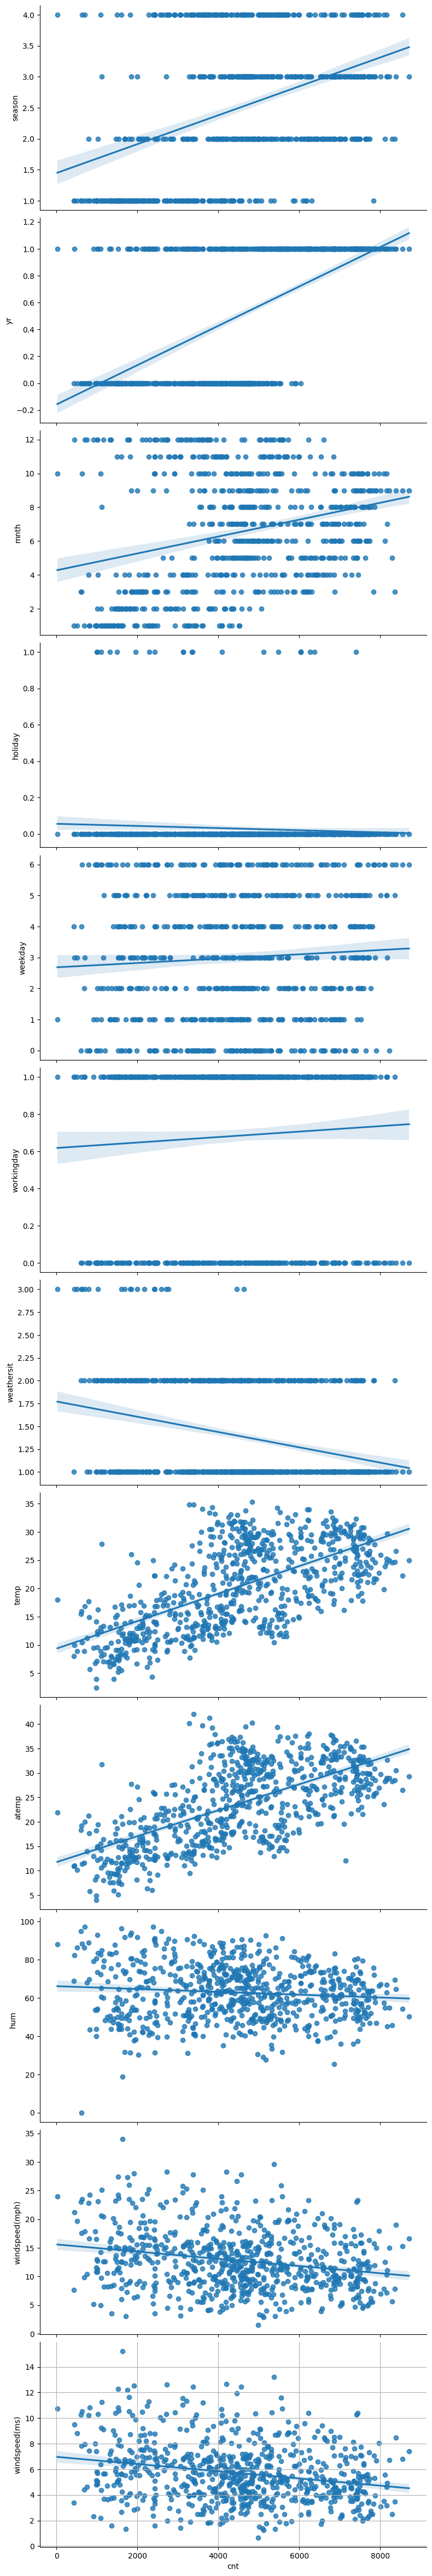

In [5]:
import seaborn as sns
sns.pairplot(df,
             y_vars=['season','yr','mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)' ],
             x_vars=['cnt'],
             height=4, aspect=2,
             kind='reg',
            )
plt.grid()
plt.show()

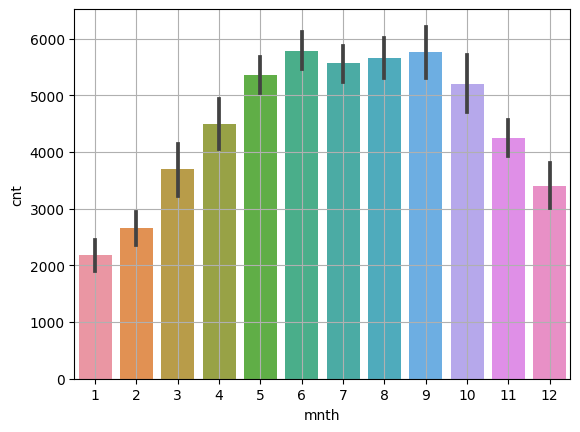

In [8]:
sns.barplot(data=df, x='mnth', y='cnt')
plt.grid()
plt.show()


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца? ***Ответ: Кількість орендованих велосипедів збільшується лінійно з 1 місяця до 6місяця. Потім з 6 по9 місяц стала кіл-ть прокатів, з 9 до 12 місяця лінійно зменьшуються ***
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно. ***Windspeed(mph), Windspeed(ms), temp, atemp ***

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [9]:
df.corrwith(df['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [10]:
temp_cnt=pd.DataFrame(
    {   'temp':df['temp'],
        'cnt':df['cnt']
        })
print('попарная корреляции между признаками temp i cnt\n',temp_cnt.corr())

atemp_cnt=pd.DataFrame(
    {   'atemp':df['atemp'],
        'cnt':df['cnt']
        })
print('попарная корреляции между признаками atemp i cnt\n',atemp_cnt.corr())

hum_cnt=pd.DataFrame(
    {   'hum':df['hum'],
        'cnt':df['cnt']
        })
print('попарная корреляции между признаками hum i cnt\n',hum_cnt.corr())

w_speed_mph=pd.DataFrame(
    {   'w_speed_mph':df['windspeed(mph)'],
        'cnt':df['cnt']
        })
print('попарная корреляции между признаками windspeed(mph) i cnt\n',w_speed_mph.corr())

w_speed_ms=pd.DataFrame(
    {   'w_speed_ms':df['windspeed(ms)'],
        'cnt':df['cnt']
        })
print('попарная корреляции между признаками windspeed(ms) i cnt\n',w_speed_ms.corr())
gen=pd.DataFrame(
    {   'temp':df['temp'],
        'atemp':df['atemp'],
        'hum':df['hum'],
        'w_speed_mph':df['windspeed(mph)'],
        'w_speed_ms':df['windspeed(ms)'],
        'cnt':df['cnt']
        })
print('взаимная корреляции между признаками  и cnt\n',gen.corr())

попарная корреляции между признаками temp i cnt
           temp       cnt
temp  1.000000  0.627494
cnt   0.627494  1.000000
попарная корреляции между признаками atemp i cnt
           atemp       cnt
atemp  1.000000  0.631066
cnt    0.631066  1.000000
попарная корреляции между признаками hum i cnt
           hum       cnt
hum  1.000000 -0.100659
cnt -0.100659  1.000000
попарная корреляции между признаками windspeed(mph) i cnt
              w_speed_mph       cnt
w_speed_mph     1.000000 -0.234545
cnt            -0.234545  1.000000
попарная корреляции между признаками windspeed(ms) i cnt
             w_speed_ms       cnt
w_speed_ms    1.000000 -0.234545
cnt          -0.234545  1.000000
взаимная корреляции между признаками  и cnt
                  temp     atemp       hum  w_speed_mph  w_speed_ms       cnt
temp         1.000000  0.991702  0.126963    -0.157944   -0.157944  0.627494
atemp        0.991702  1.000000  0.139988    -0.183643   -0.183643  0.631066
hum          0.126963  0.139988

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [11]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [12]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [220]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
df_shuffled.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
703,4,1,12,0,2,1,1,19.509153,23.45270,73.3750,11.666643,5.215308,6606
33,1,0,2,0,4,1,1,7.665237,8.89390,43.7826,18.609384,8.318902,1550
300,4,0,10,0,5,1,2,13.564153,15.94060,58.5833,15.375093,6.873086,3747
456,2,1,4,0,0,0,2,17.459153,20.86435,67.6250,11.541889,5.159539,6041
633,4,1,9,0,2,1,1,22.550000,27.20895,57.0000,15.833507,7.078009,7538


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [14]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [15]:
ln_model=LinearRegression()
ln_model.fit(X,y)
print('W0\n',ln_model.intercept_)
print('Wi\n',ln_model.coef_)

W0
 4504.354528214392
Wi
 [ 5.70863796e+02  1.02196538e+03 -1.41301745e+02 -8.67593446e+01
  1.37225064e+02  5.63918818e+01 -3.30226462e+02  3.67483733e+02
  5.85549386e+02 -1.45614306e+02  1.24571384e+13 -1.24571384e+13]


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [26]:
from sklearn import linear_model
reg_lasso = linear_model.Lasso()
reg_lasso.fit(X,y)
print('W0\n',reg_lasso.intercept_)
print('Wi\n',reg_lasso.coef_)
reg_lasso.score(X,y)

W0
 4504.3488372093025
Wi
 [ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
  1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
  5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]


0.800239476118262

Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [27]:
reg_ridge=linear_model.Ridge()
reg_ridge.fit(X,y)
print('W0\n',reg_ridge.intercept_)
print('Wi\n',reg_ridge.coef_)
reg_ridge.score(X,y)

W0
 4504.3488372093025
Wi
 [ 563.06457225 1018.94837879 -131.87332028  -86.746098    138.00511118
   55.90311038 -332.3497885   386.45788919  566.34704706 -145.0713273
  -99.25944108  -99.25944115]


0.8002417905136303

### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [40]:
alphas = np.arange(1, 500, 50)

coefs_lasso2 =[]
coefs_ridge2 = []

for alpha in alphas:
    ridge=linear_model.Ridge(alpha=alpha)
    lasso=linear_model.Lasso(alpha=alpha)
    ridge.fit(X,y)
    lasso.fit(X,y)
    coefs_ridge2.append(ridge.coef_)
    coefs_lasso2.append(lasso.coef_)
coefs_lasso=np.array(coefs_lasso2)
coefs_ridge=np.array(coefs_ridge2)
coefs_ridge

array([[ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
         138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
         566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115],
       [ 461.1786324 ,  954.30774189,  -41.56545001,  -84.91347027,
         126.60366663,   54.2516911 , -313.27515141,  458.90147709,
         481.44350031, -151.29101033, -101.62731482, -101.62731483],
       [ 403.97653045,  898.08362212,    5.67424346,  -81.91106159,
         117.94141144,   52.72848389, -298.40898086,  455.28986839,
         467.43141748, -152.68605059, -102.10167084, -102.10167084],
       [ 366.60423851,  848.46346471,   34.02728278,  -78.77196479,
         110.68012006,   51.25719208, -286.12515935,  447.47982533,
         455.75402966, -151.48320603, -102.00537592, -102.00537593],
       [ 339.74528956,  804.25104797,   52.48987295,  -75.71740756,
         104.40346414,   49.84189502, -275.48609488,  438.50968939,
         444.7642744 , -148.94396978, -101.5

Проанализируйте динамику весов при увеличении параметра регуляризации:

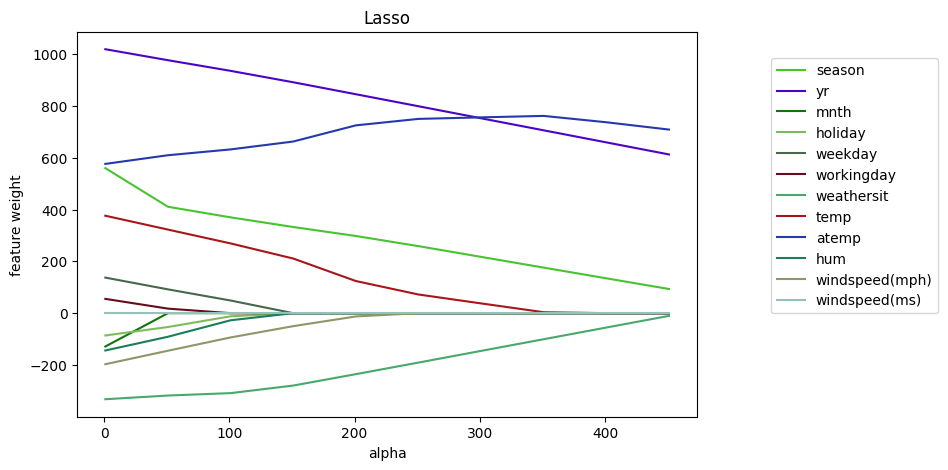

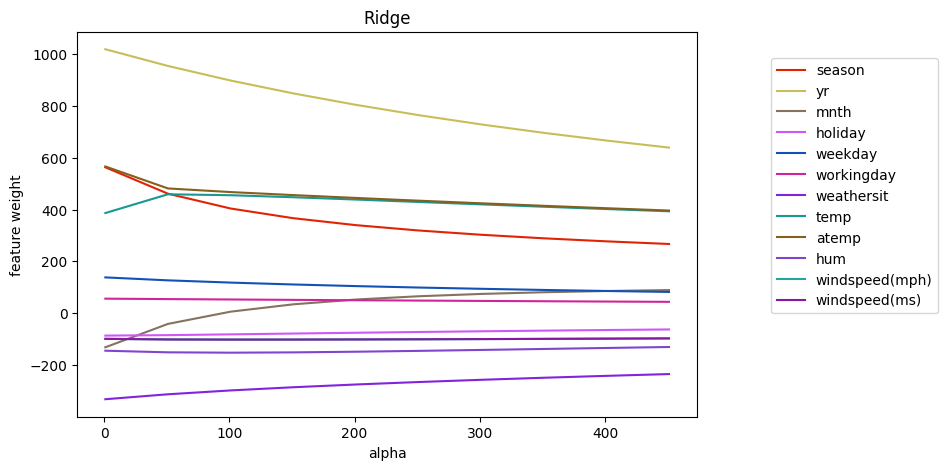

In [39]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?  ***Ответ:Lasso***
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит. ***Ответ: веса стремятся к 0. Это происходит из-за подхода к нормированию весов. в Лассо используется сумма модулей. Пересечение минимума весов с cost function происходит при пересечении с абсциссой или ординатой норм весов. Смотри ссылку ниже. ***
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$. ***Ответ: Да можном. При ла Лассо windspeed исключается `alpha > 0` А Ridge - не исключает. Если критерий исключения равенста веса =0, у Ridge не наблюдается. Да есть отрицательные или около 0, но не нулевые  ***
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков? ***Ответ: Думаю Лассо, от отсеит не влияющие веса - или неинформативные признаки ***

[Текст ссылки](https://online.stat.psu.edu/onlinecourses/sites/stat508/files/lesson05/image_09.gif)

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [ ]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [101]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(cv=3,alphas=alphas).fit(X,y)
print('Alpha',regressor.alpha_)
print('Coeficients\n',regressor.coef_)

Alpha 6
Coeficients
 [ 5.32018983e+02  1.01506022e+03 -1.00039526e+02 -8.32939599e+01
  1.32504465e+02  5.15570856e+01 -3.30559857e+02  3.70679855e+02
  5.81396931e+02 -1.40007406e+02 -1.91771408e+02 -2.68547023e-08]


In [140]:
def creat_plot2(data, alphas):
  avg_mse=[]
  for i in range(data.shape[0]):
    mse_i=data[i].mean()
    avg_mse.append(mse_i)

  avg_mse=np.array(avg_mse)

  plt.figure(figsize=(8,4))
  plt.plot(alphas, avg_mse)
  plt.xlabel("alpha2")
  plt.ylabel("feature weight2")
  plt.grid()
  plt.show()

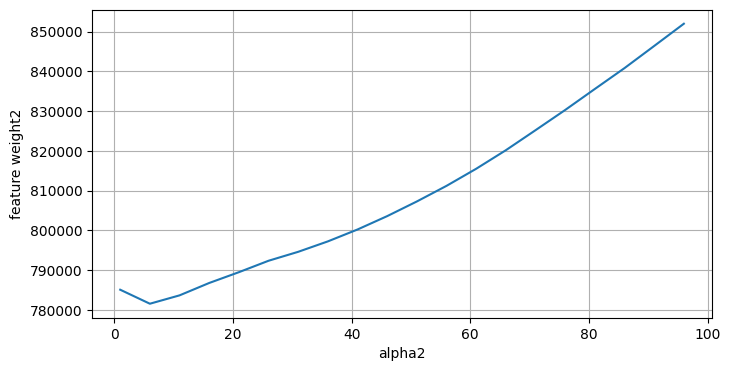

In [141]:
creat_plot2(regressor.mse_path_,regressor.alphas_)

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


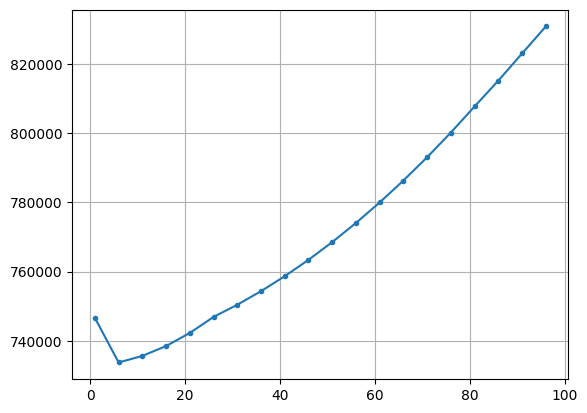

Min value at a set 733725.7604052249
Best alpha for a set 6


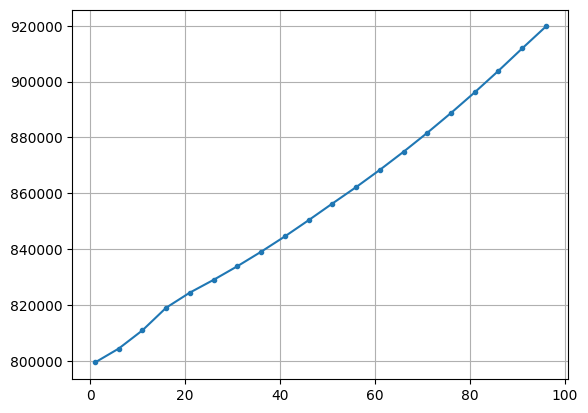

Min value at a set 799433.1673691692
Best alpha for a set 1


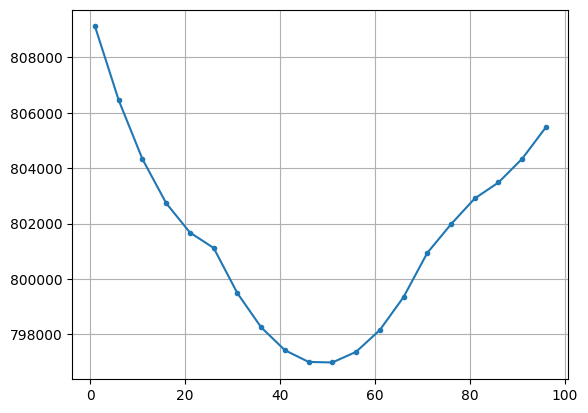

Min value at a set 796979.8955193626
Best alpha for a set 51


In [178]:
for i in range(regressor.mse_path_.shape[1]):
  plt.plot(regressor.alphas_, regressor.mse_path_[:,i], marker='.')
  plt.grid()
  plt.show()
  print('Min value at a set',regressor.mse_path_[:,i].min())
  print('Best alpha for a set',regressor.alphas_[np.argmin(regressor.mse_path_[:,i])])


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

__Ответ:__

In [ ]:
coefi=pd.DataFrame({
    'weights':df.columns[0:-1],
    'coef': regressor.coef_
})

In [202]:
coefi.sort_values(by=['coef'], ascending=False)

,weights,coef
1,yr,1.015060e+03
8,atemp,5.813969e+02
0,season,5.320190e+02
7,temp,3.706799e+02
4,weekday,1.325045e+02
5,workingday,5.155709e+01
11,windspeed(ms),-2.685470e-08
3,holiday,-8.329396e+01
2,mnth,-1.000395e+02
9,hum,-1.400074e+02


4 признака с наибольшими (положительными) коэфициентами:
year, atemp, season, temp

Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Ответ: от признаков atemp и temp да видна. от признаков year и season неочевидна

Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? Ответ: С точки зрения линейной функции да. Здравого смысла тоже, чем теплее и чем ближе теплые сезоны да. От Года нет

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [203]:
coefi.sort_values(by=['coef'], ascending=True)

,weights,coef
6,weathersit,-3.305599e+02
10,windspeed(mph),-1.917714e+02
9,hum,-1.400074e+02
2,mnth,-1.000395e+02
3,holiday,-8.329396e+01
11,windspeed(ms),-2.685470e-08
5,workingday,5.155709e+01
4,weekday,1.325045e+02
7,temp,3.706799e+02
0,season,5.320190e+02


Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Ответ: weathersit, windspeed(mph), hum
Видна ли убывающая линейная зависимость? Да видна
Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?Верно чем больше скорость ветра, влажность тем меньше хочеться катаься на велосипеде:) Учитывая weathersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман). Чем меньше показатель тем лучше погода и больше хочеться кататься.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [219]:
coefi[(coefi['coef']< 0.001) & (coefi['coef']> -0.001)]

,weights,coef
11,windspeed(ms),-2.685470e-08


Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Ответ windspeed(ms).
Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Из-за кореляция с парамером windspeed(mph)
Верно ли, что они никак не влияют на спрос на велосипеды? Ответ: не верно. Он влияет. Но математичекой точки зрения надо оставлять один набор параметров. А не 2 но в разной системе измерений

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.